In [1]:
using Pkg
Pkg.activate("C:/Users/lisah/Documents/Repos/ma-code")
include("c:/Users/lisah/Documents/Repos/ma-code/src/src.jl")

  Activating project at `C:\Users\lisah\Documents\Repos\ma-code`


Main.Src

In [85]:
using Distributions, DataStructures, GlobalSensitivityAnalysis, Plots, JLD2

## Computation of Sobol Indices

Reference:

Andrea Saltelli et al. Global Sensitivity Analysis: The Primer. Chichester, UK: John
Wiley & Sons, 2008. isbn: 978-0-470-72518-4.

In [3]:
N = 2 # sample size for MC estimation of SI 
t_end = 50.0
M = Int(t_end * 10) # pick M solution trajectory time points for computing indices 
#M = 5 # for testing
noise = 0.0
t_fixed = true
prm_num = 1; # parameter for which SA is conducted

In [4]:
# define densities
dens_a = Uniform(0.94,2.81)
dens_m = Uniform(0.45-0.45*0.2,0.45+0.45*0.2)
dens_n0 = Uniform(0.5,1.5)
dens_w0 = Uniform(0.5,1.5)

Uniform{Float64}(a=0.5, b=1.5)

### manually

note: unfinished, probably useless, delete later

generate sample matrices A,B,C

In [33]:
# generate sample matrices A,B,C
k = 4 # number of parameters
A, B = zeros(N, k), zeros(N, k)

A[:, 1], B[:, 1] = rand(dens_a, N), rand(dens_a, N) # achtung das klappt nicht mit seed
A[:, 2], B[:, 2] = rand(dens_m, N), rand(dens_m, N)
A[:, 3], B[:, 3] = rand(dens_w0, N), rand(dens_w0, N)
A[:, 4], B[:, 4] = rand(dens_n0, N), rand(dens_n0, N)

C = deepcopy(B)
C[:, prm_num] = A[:,prm_num]

sam_prm_mat = [A, B, C];

evaluate model on matrices

In [34]:
# each matrix row corresponds to set of parameters used by model
# output: 3 evaluation matrices of size NxM per trajectory 
yn, yw = [],[]

for Mat in sam_prm_mat
    n, w = zeros(N,M), zeros(N,M)
    for i in 1:N 
        a, m, w0, n0 = Mat[i, 1:k]
        hprm = Src.Hyperprm(w0,n0,a,m,M,noise)
        sol = Src.sol_klausmeier(hprm, t_fixed=t_fixed, t_end = t_end)
        sol = Src.randomize_data!(sol, hprm.noise) # probably don't use random data ?
        n[i,:], w[i, :] = sol[!, "n"], sol[!, "w"]
    end
    push!(yn, n), push!(yw, w) #
end

# extract evaluation matrices for both trajectory
nA, nB, nC = yn[1], yn[2], yn[3]
wA, wB, wC = yw[1], yw[2], yw[3];

### use Julia Pkg

In [74]:
# create sample matrix
N = 5000
data = SobolData(
    params = OrderedDict(:a => dens_a,
    :m => dens_m,
    :w0 => dens_w0,
    :n0 => dens_n0),
    N=N
)
samples = GlobalSensitivityAnalysis.sample(data);

In [ ]:
# evaluate model on sample matrix
n, w = zeros(size(samples, 1),M), zeros(size(samples, 1),M)
for i in 1:size(samples, 1) 
    a, m, w0, n0 = samples[i, :]
    hprm = Src.Hyperprm(w0,n0,a,m,M,noise)
    sol = Src.sol_klausmeier(hprm, t_fixed=t_fixed, t_end=t_end)
    sol = Src.randomize_data!(sol, hprm.noise) # probably don't use noisy data ?
    n[i,:], w[i,:] = sol[!, "n"], sol[!, "w"]
end

In [76]:
# compute sobol indices
sobol_n = [analyze(data, n[:,j]) for j in 1:M]
sobol_w = [analyze(data, w[:,j]) for j in 1:M];

Calculating indices for 4 parameters ... 100%|███████████| Time: 0:00:08
Calculating indices for 4 parameters ... 100%|███████████| Time: 0:00:03
Calculating indices for 4 parameters ... 100%|███████████| Time: 0:00:03
Calculating indices for 4 parameters ... 100%|███████████| Time: 0:00:03
Calculating indices for 4 parameters ... 100%|███████████| Time: 0:00:03
Calculating indices for 4 parameters ... 100%|███████████| Time: 0:00:03
Calculating indices for 4 parameters ... 100%|███████████| Time: 0:00:03
Calculating indices for 4 parameters ... 100%|███████████| Time: 0:00:03
Calculating indices for 4 parameters ... 100%|███████████| Time: 0:00:03
Calculating indices for 4 parameters ... 100%|███████████| Time: 0:00:03
Calculating indices for 4 parameters ... 100%|███████████| Time: 0:00:03
Calculating indices for 4 parameters ... 100%|███████████| Time: 0:00:03
Calculating indices for 4 parameters ... 100%|███████████| Time: 0:00:03
Calculating indices for 4 parameters ... 100%|█████

In [87]:
# store
@save "C:/Users/lisah/Documents/Repos/ma-code/temp_saves/sobol_n_$(N)_$(t_end)_$M.jld2" sobol_n
@save "C:/Users/lisah/Documents/Repos/ma-code/temp_saves/sobol_w_$(N)_$(t_end)_$M.jld2" sobol_w

### plots

In [77]:
# create time axis
a, m, w0, n0 = samples[1, :]
hprm = Src.Hyperprm(w0,n0,a,m,M,noise)
sol = Src.sol_klausmeier(hprm, t_fixed=t_fixed, t_end=t_end)
times = sol[!,"time"];

In [125]:
# needed for plotting
colors = [:blue, :turquoise, :orange, :red]
parameters = ["a", "m", "w0", "n0"];

In [126]:
# extract indices for plotting
n_fo_si = [sobol_n[i][:firstorder] for i in 1:M]
n_to_si = [sobol_n[i][:totalorder] for i in 1:M]

w_fo_si = [sobol_w[i][:firstorder] for i in 1:M]
w_to_si = [sobol_w[i][:totalorder] for i in 1:M];

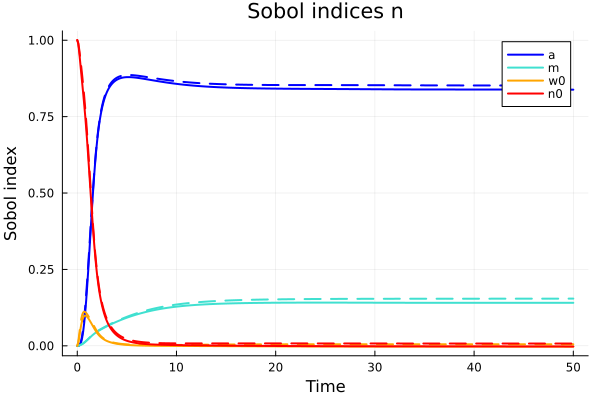

In [128]:
# plot n compartment
plot_n = plot(legend=:topright)
for k in 1:4
    col = colors[k]
    prm = parameters[k]
    plot!(times, getindex.(n_fo_si, k), label="$prm", lw=2, color=col, linestyle=:solid)
    plot!(times, getindex.(n_to_si, k), label="", lw=2, color=col, linestyle=:dash)
end
xlabel!("Time")
ylabel!("Sobol index")
title!("Sobol indices n")

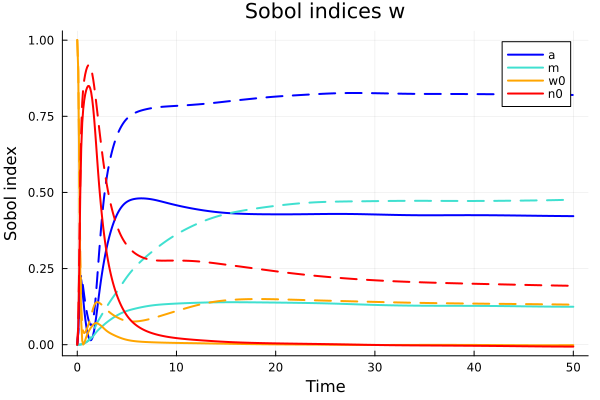

In [129]:
# plot w compartment
plot_w = plot(legend=:topright)
for k in 1:4
    col = colors[k]
    prm = parameters[k]
    plot!(times, getindex.(w_fo_si, k), label="$prm", lw=2, color=col, linestyle=:solid)
    plot!(times, getindex.(w_to_si, k), label="", lw=2, color=col, linestyle=:dash)
end
xlabel!("Time")
ylabel!("Sobol index")
title!("Sobol indices w")